In [ ]:
%reload_ext autoreload
#%load_ext autoreload
%autoreload 1
%matplotlib inline

import datetime
import pandas as pd
#import modin.pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm import tqdm


#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn.preprocessing import FunctionTransformer, StandardScaler, QuantileTransformer,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope, EmpiricalCovariance, MinCovDet
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering

from umap import UMAP
from sklearn.decomposition import PCA, FactorAnalysis, NMF, SparseCoder, SparsePCA
from sklearn.pipeline import Pipeline

from scipy.stats import chi2

import os
import sys
import gc
import joblib

os.chdir("T:\\laupodteam\\AIOS\\Bram\\notebooks\\code_dev\\celldyn_embedder\\sandbox")
#os.chdir("/media/UMCU/notebooks/code_dev/celldyn_embedder/sandbox")
sns.set_style("whitegrid")

write_to_disk = False
read_from_disk = True

from numba import jit, njit, float32
from functools import lru_cache, cached_property
from numpy import linalg as la
from collections import defaultdict
#import ray
#ray.init()

from hembedder.utils.distance import poincarre_dist, fractional_distance, hyperboloid_dist, Distance
from hembedder.prepping import quality
from hembedder.prepping import transformer
from hembedder.prepping import recombinator
from hembedder.prepping import imputer

In [ ]:
current_directory = os.path.dirname(os.path.realpath("."))

In [ ]:
test = False

cleaning = ['qc']
scaling = ['default']
missingness = ['miceforest'] # 'missingforest, 'drop'
feature_selection = []
outlier_method = ['isolationforest'] # clip, isolationforest, lof, oneclass_svm, mahalanobis
recombine = True

In [ ]:
# function to set all values to their 1st and 99th percentile
def clip_outliers(df, cols, qL=0.01, qH=0.99):
    for col in cols:
        df.loc[:, col] = df[col].clip(df[col].quantile(qL), df[col].quantile(qH))
    return df

# get entropy over a dimension
def get_entropy(data, dim):
    # get the unique values and their counts
    uniq = np.unique(data.loc[:,dim], return_counts=True)
    # get the total number of observations
    total = np.sum(uniq[1])
    # get the probabilities
    probs = uniq[1] / total
    # get the entropy
    entropy = np.sum(probs * np.log2(probs))
    return entropy

In [ ]:
#cpath = "T:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_cleaned_transformed_imputed_ALL_with_ratios.feather"
#cpath = "T:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_FULL_transformed_df.feather"
cpath = "T:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_checked.feather"
celldyn = pd.read_feather(cpath)

if test:
    celldyn = celldyn.sample(5000)

celldyn.columns = celldyn.columns.str.lower()

celldyn = celldyn.query('c_b_ht>0.2 and c_b_hb>0.2 and c_b_rbco>0.1 and c_b_rbco<100 and c_b_hb<20')
celldyn.drop(['c_b_pblst', 'c_b_pnrbc', 'c_b_pbnd', 
              'c_b_blst', 'c_b_vlym', 'c_b_nrbc', 
              'c_b_bnd', 'c_b_ig',
              'c_b_pig', 'c_b_pvlym'], axis=1, inplace=True, errors='ignore')

meas_cols =[c for c in celldyn.columns if 'c_b_' in c]+['plt']

In [ ]:
celldyn = celldyn.drop([c for c in celldyn.columns if ':' in c], axis=1)

In [ ]:
celldyn_original = celldyn.copy()

In [ ]:
celldyn = celldyn.assign(rbci_over_o=celldyn.c_b_rbco/celldyn.c_b_rbci)
celldyn = celldyn.assign(plti_over_o=celldyn.c_b_plti/celldyn.c_b_plto)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
sns.scatterplot(data=celldyn.sample(10000), x='c_b_rbci', y='c_b_rbco', ax=ax[0], color='black')
sns.scatterplot(data=celldyn.sample(10000), x='c_b_plti', y='c_b_plto', ax=ax[1], color='black')
fig.suptitle("RBCi vs RBCo and PLTi vs PLTo")

In [ ]:
from matplotlib.patches import Circle

In [ ]:
min_ratio, max_ratio = 0.9, 1.1
r = np.max([np.abs(np.log10(min_ratio)), np.log10(max_ratio)])

fig, ax = plt.subplots(figsize=(10, 6))
plot_df = celldyn.sample(100000)[['rbci_over_o', 'plti_over_o']]
plot_df = plot_df.assign(rbci_over_o_log=lambda x: np.log10(x['rbci_over_o']))
plot_df = plot_df.assign(plti_over_o_log=lambda x: np.log10(x['plti_over_o']))
sns.scatterplot(data=plot_df, x='rbci_over_o_log', y='plti_over_o_log', ax=ax, color='black', alpha=0.1)
plt.axvline(0, color='red')
plt.axhline(0, color='red')
plt.xlabel('log10(RBCI / O)')
plt.ylabel('log10(PLTI / O)')
plt.xlim(-1,1)
plt.ylim(-0.25,1)

center = (0,0)
radius = r
circle = Circle(center, radius, color='red', fill=False)

ax. add_patch(circle)
# ax. set_aspect('equal')

In [ ]:
sns.displot(data=celldyn.sample(2500), x="age", hue="gender", alpha=0.4, kde=True)

In [ ]:
#celldyn['gender']= celldyn.gender.str.decode(encoding='latin1')
celldyn['age'] = celldyn.age.astype(int)
celldyn['meas_hour'] = celldyn['asp_dt'].dt.hour#   apply(lambda x: x.hour)
celldyn['draw_hour'] = celldyn['afname_dt'].dt.hour # .apply(lambda x: x.hour)
celldyn['time_to_measurement'] = (celldyn.asp_dt-celldyn.afname_dt).dt.total_seconds()
celldyn['time_to_measurement'] = celldyn['time_to_measurement']//3600

In [ ]:
print(celldyn.shape)

In [ ]:
cond = (celldyn.time_to_measurement<6) & (celldyn.time_to_measurement>-2)
celldyn = celldyn[cond]
print(celldyn.shape)

In [ ]:
meta_cols = ['asp_dt', 'analyzer', 'studyid_alle_celldyn', 
             'time_to_measurement', 'gender', 'age' , 'afname_dt',
             'day_of_year', 'week_of_year', 'year', 'first_day',
              'draw_hour', 'meas_hour']
count_columns = [c for c in celldyn.columns if 'c_cnt' in c]
mode_columns = [c for c in celldyn.columns if 'c_m' in c]
susp_columns = [c for c in celldyn.columns if 'c_s' in c]
alert_columns = [c for c in celldyn.columns if 'alrt' in c]
fail_columns = [c for c in celldyn.columns if 'fail' in c]
all_cols  = meta_cols+meas_cols+mode_columns+susp_columns+alert_columns+count_columns+fail_columns
other_cols = [c for c in celldyn.columns if c not in all_cols]

## Cleaning

In [ ]:
entropies = []
for c in meas_cols:
   entropies.append((c, get_entropy(celldyn,c)))

In [ ]:
drop_cols = [t[0] for t in entropies if t[1]>-5]
meas_cols = [c for c in meas_cols if c not in drop_cols]
celldyn.drop(drop_cols, axis=1, inplace=True)

print(drop_cols)

In [ ]:
if 'qc' in cleaning:
    qc = quality.QcControl(param_file=os.path.join(current_directory, "assets/CelldynParams.xlsx"), 
                          cols_include=meas_cols)
    qc.fit(celldyn)
    df = qc.transform(celldyn)
    celldyn = df

In [ ]:
print(f'Number of missings : {celldyn[meas_cols].isna().sum().sum()}')
print(f'Number of missings, originally : {celldyn_original[meas_cols].isna().sum().sum()}')

### Removal of obvious outliers

* Look at the distribution of the data and remove obvious outliers.
* Look at the ratio of the plti/plto and rbci/rbco and remove obvious outliers.

In [ ]:
plt.hist(np.log10(celldyn[meas_cols].values.ravel()+1), bins=50);

In [ ]:
c1 = celldyn.loc[celldyn[meas_cols].max(axis=1)>1000, meas_cols].idxmax(axis=1)
include = c1[c1.isin(['c_b_plti', 'c_b_plto', 'plt'])].index
exclude = c1[~c1.isin(['c_b_plti', 'c_b_plto', 'plt'])].index
celldyn = celldyn.drop(exclude, axis=0)

## Scaling

In [ ]:
if 'default' in scaling:
    CellDynTransformer = transformer.CellDynTrans(
                                    log_scale=['c_b_peos', 'c_b_phpo', 'c_b_pmac',
                                               'c_b_pmic', 'c_b_pretc', 'c_b_prp', 
                                               'c_b_rbcfcv', 'c_b_seg', 'c_b_neu',
                                               'c_b_plto', 'c_b_plti', 'c_b_mone',
                                               'c_b_mon', 'c_b_lyme', 'c_b_lym',
                                               'c_b_hdw'],
                                    ord_scale=[],
                                    remove_original_columns=False)
    df = CellDynTransformer.fit_transform(celldyn[meas_cols])
    celldyn[meas_cols] = df

## Imputing

In [ ]:
if 'miceforest' in missingness:
    imputer_clf = imputer.Imputer(imputer='forest',
                        backend='miceforest', 
                        meas_cols = meas_cols,
                        verbose=True,
                        iterations=3, 
                        num_estimators=75, 
                        num_match_candidates=5,
                        save_all_iterations=False,
                        data_subset=0.25,
                        synthesize_working_data=True
                        )
    imputer_clf.fit(celldyn[meas_cols])
    celldyn[meas_cols] = imputer_clf.transform(celldyn[meas_cols])
elif 'knn' in missingness:
    imputer_clf = KNNImputer(n_neighbors=10, weights="distance")
    celldyn[meas_cols] = imputer_clf.fit_transform(celldyn[meas_cols])
elif 'mean' in missingness:
    imputer_clf = SimpleImputer(strategy='mean')
    celldyn[meas_cols] = imputer_clf.fit_transform(celldyn[meas_cols])

## Feature selection

In [ ]:
# make (BaseEstimator, TransformerMixin) class that extracts clustered features 
# using agglomerative clustering

class AggFeatSel(AgglomerativeClustering):
    def __init__(self, n_clusters=2, metric='euclidean', memory=None, 
                 connectivity=None, compute_full_tree='auto', linkage='ward', 
                 col_names=None):
        
        super().__init__(n_clusters=n_clusters, metric=metric, 
                         memory=memory, connectivity=connectivity, 
                         compute_full_tree=compute_full_tree, 
                         linkage=linkage)
        self.col_names = col_names

    def fit(self, X, y=None):
        super().fit(X)
        return self

    def get_selected_features(self):
        '''
            For each distinct label, arbitrarily select one of the
            columns to represent the cluster
        '''
        _, ui = np.unique(self.labels_, return_index=True)
        
        # TODO: add minimum threshold for similarity

        return list(np.array(self.col_names)[ui])

In [ ]:
if 'agglomerative' in feature_selection:
    featSel = AggFeatSel(n_clusters=5, col_names=meas_cols)
    featSel.fit(celldyn[meas_cols].T)
    meas_cols = featSel.get_selected_features()

# Treat outliers

In [ ]:
le_pipe = [
        ('scaler', QuantileTransformer(output_distribution='normal', random_state=42)),
]

if 'clip' in outlier_method:
    celldyn = clip_outliers(celldyn, meas_cols, qL=0.01, qH=0.99)

if 'isolationforest' in outlier_method:
    # Isolation forest
    le_pipe.append(('clf', IsolationForest(max_samples=100, random_state=42)))
    pipe = Pipeline(le_pipe, verbose=True)

    pipe.fit(celldyn[meas_cols])
    y_pred_train = pipe.predict(celldyn[meas_cols])
    celldyn['outlier_iso'] = y_pred_train
    meta_cols.append('outlier_iso')
if "lof" in outlier_method:
    # Local outlier factor
    le_pipe.append((LocalOutlierFactor(n_neighbors=20)))
    pipe = Pipeline(le_pipe, verbose=True)

    pipe.fit(celldyn[meas_cols])
    y_pred_train = pipe.predict(celldyn[meas_cols])
    celldyn['outlier_lof'] = y_pred_train
    meta_cols.append('outlier_lof')
if 'oneclass_svm' in outlier_method:
    # One class SVM
    le_pipe.append(('clf', OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)))
    pipe = Pipeline(le_pipe, verbose=True)

    pipe.fit(celldyn[meas_cols])
    y_pred_train = pipe.predict(celldyn[meas_cols])
    celldyn['outlier_svm'] = y_pred_train
    meta_cols.append('outlier_svm')
    
if 'mahalanobis' in outlier_method:
    # robust mahalanobis distance
    pipe = Pipeline(le_pipe, verbose=True)
    pipe.fit(celldyn[meas_cols])
    new_data = pipe.transform(celldyn[meas_cols])
    clf_cov = MinCovDet(random_state=0).fit(new_data)
    mahal_dist = clf_cov.mahalanobis(new_data)

    # add probability by comparing mahalanobis distance to chi2 distribution
    celldyn['mahal_dist'] = mahal_dist
    celldyn['mahal_prob'] = 1 - chi2.cdf(mahal_dist, 2)
    meta_cols.extend(['mahal_dist', 'mahal_prob'])


# Recombinator

In [ ]:
if recombine:
    recombiner = recombinator.CellDynRecombinator(scaler=None, base_combos=True, only_output_combos=True)
    recombiner.fit(celldyn[meas_cols])
    celldyn_combo = pd.DataFrame(data=recombiner.transform(celldyn[meas_cols]),
                                 columns=recombiner.out_columns,
                                 index=celldyn.index)
    celldyn = pd.concat([celldyn, celldyn_combo], axis=1)
    

## Seasonal variation

In [ ]:
celldyn = pd.read_parquet('T://laupodteam/AIOS/Bram/data/CellDyn/artifacts/celldyn_for_seasonality.parquet')

In [ ]:
sns.lineplot(data=celldyn.loc[celldyn.gender.isin(['M', 'F'])], x='week_of_year', y='age', hue='gender')

In [ ]:
plot_df = celldyn.groupby('week_of_year').agg({'gender': lambda x: sum(x=='M')/sum(x=='F')}).reset_index()
sns.lineplot(data=plot_df, x='week_of_year', y='gender')
plt.title('Ratio Male/Female patients')

In [ ]:
celldyn = celldyn.assign(abs_week = lambda x: x['week_of_year'] + 52*(x['year']-x['year'].min()))

In [ ]:
meas_cols = [c for c in celldyn.columns if 'c_b_' in c]+['plt']

In [ ]:
# add COMBO cols
meas_cols = meas_cols + [c for c in celldyn.columns if "COMBO" in c]

In [ ]:
celldyn['month_of_year'] = celldyn.afname_dt.dt.month

In [ ]:
var = 'c_b_pneu'
fig, ax = plt.subplots(nrows=2, figsize=(19, 12))
plt.style.use('seaborn-whitegrid')
plot_df = celldyn.query('year<2020 & week_of_year<51')\
                .groupby(['week_of_year'])\
                .agg({var: 'median'}).reset_index()
sns.lineplot(data=plot_df, x='week_of_year', y=var, palette='Set2', ax=ax[0], legend=False)
ax[0].set_title(f'Median of {var} by week of year')
#ax.set_xlim(0, 700)
#ax.set_ylim(0.55, 0.65)

plot_df = celldyn.query('year<2020 & week_of_year<51')\
                .groupby(['draw_hour'])\
                .agg({var: 'median'}).reset_index()
sns.lineplot(data=plot_df, x='draw_hour', y=var, palette='Set2', ax=ax[1], legend=False)
ax[1].set_title(f'Median of {var} by draw hour')

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
celldyn = celldyn.assign(abs_month=lambda x: x['month_of_year'] + 12*(x['year']-x['year'].min()))

In [ ]:
celldyn['weekday_hour'] = celldyn['afname_dt'].dt.weekday*24 + celldyn['afname_dt'].dt.hour

Text(0.5, 1.0, 'Median of c_b_hb by draw hour-over-the-week')

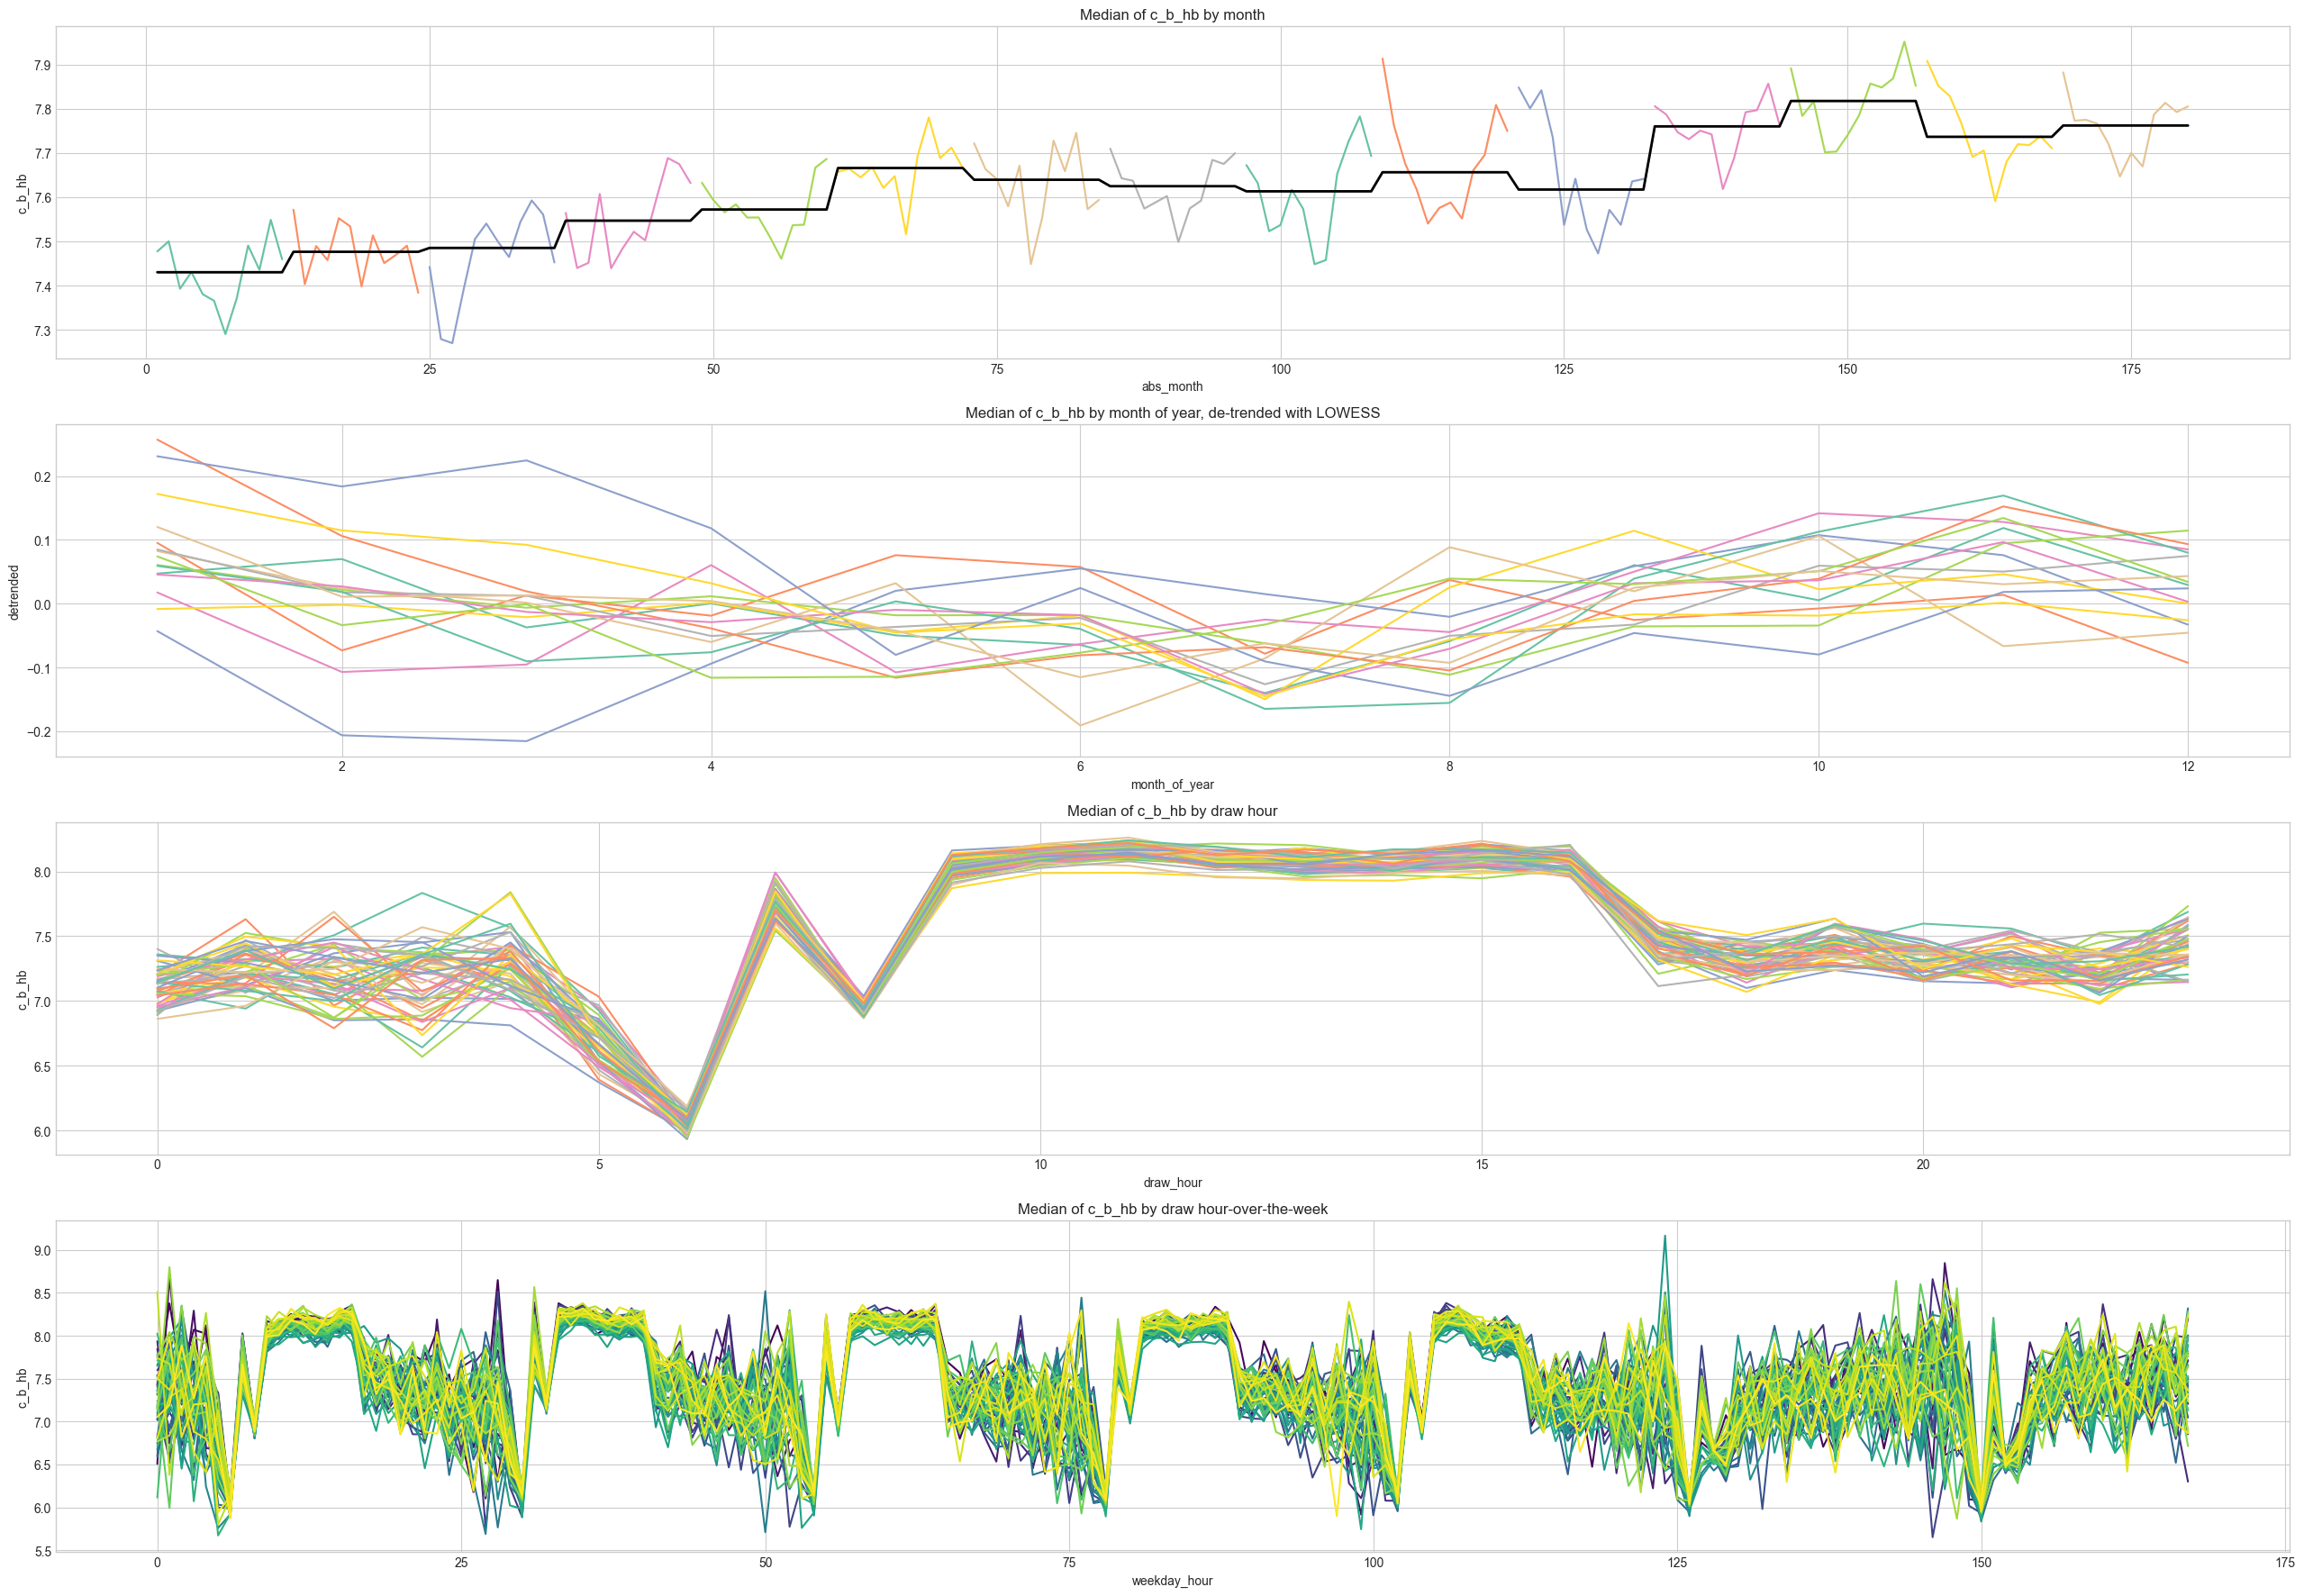

In [294]:
var = 'c_b_hb'

fig, ax = plt.subplots(nrows=4, figsize=(32, 22))

plt.style.use('seaborn-whitegrid')
plot_df = celldyn.query('year<2020 & 1<week_of_year<52')\
                .groupby(['abs_month', 'year'])\
                .agg({var: 'median'}).reset_index()

smoothed= lowess(plot_df[var],
                 plot_df['year'], 
                 frac=0.1, it=3, missing='drop')
tmp = pd.DataFrame(data=smoothed, columns=['year', 'sval'])
plot_df = pd.merge(plot_df, tmp, on='year')

sns.lineplot(data=plot_df, x='abs_month', y=var, hue='year', 
            palette='Set2', ax=ax[0], legend=False)
sns.lineplot(data=plot_df, x='abs_month', y='sval', ax=ax[0], color='black', lw=2, legend=False)
ax[0].set_title(f'Median of {var} by month')


#################
plot_df = celldyn.query('year<2020 & 1<week_of_year<52')\
                .groupby(['abs_month', 'month_of_year', 'year'])\
                .agg({var: 'median'}).reset_index()
plot_df = plot_df.assign(detrended=plot_df[var]-smoothed[:,1])

#sns.lineplot(data=plot_df, x='week_of_year', y=var, hue='year', 
#            palette='Set2', ax=ax[1], legend=False)
sns.lineplot(data=plot_df, x='month_of_year', y='detrended', hue='year',
            palette='Set2', ax=ax[1], legend=False)
ax[1].set_title(f'Median of {var} by month of year, de-trended with LOWESS')
#################
plot_df = celldyn.query('year<2020 & week_of_year<52')\
                .groupby(['draw_hour', 'week_of_year'])\
                .agg({var: 'median'}).reset_index()
sns.lineplot(data=plot_df, x='draw_hour', y=var, hue='week_of_year', 
            palette='Set2', ax=ax[2], legend=False)
ax[2].set_title(f'Median of {var} by draw hour')


plot_df = celldyn.query('year<2020 & week_of_year<52')\
                .groupby(['weekday_hour', 'week_of_year'])\
                .agg({var: 'median'}).reset_index()
sns.lineplot(data=plot_df, x='weekday_hour', y=var, hue='week_of_year', 
            palette='viridis', ax=ax[3], legend=False)
ax[3].set_title(f'Median of {var} by draw hour-over-the-week')

In [201]:
# non-linear least squares fitting of a function to data
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# function to fit is : y = A + B * (cos(2*pi*(week-offset)/52))

from scipy.optimize import curve_fit

def cosfun(x, A, B, offset, base_per=52):
        return A + B * np.cos(2*np.pi*(x-offset)/base_per)
    
def cf(x, y, A=1, B=1, offset=0, base_per=52):
    return curve_fit(lambda x, A, B,offset: cosfun(x, A, B, offset, base_per), 
                     x, y, p0=[A, B, offset])

# fit the function
var = 'c_b_pneu'
popt_MoY, pcov_MoY = cf(x=celldyn.dropna(subset=[var])\
                                     .query('year<2020 & 1<week_of_year<51').month_of_year, 
                        y=celldyn.dropna(subset=[var])\
                                     .query('year<2020 & 1<week_of_year<51')[var], 
                        A=1, B=1,offset=celldyn[var].mean(), base_per=12)

popt_WoY, pcov_WoY = cf(x=celldyn.dropna(subset=[var])\
                                     .query('year<2020 & 1<week_of_year<51').week_of_year, 
                        y=celldyn.dropna(subset=[var])\
                                     .query('year<2020 & 1<week_of_year<51')[var], 
                        A=1, B=1,offset=celldyn[var].mean(), base_per=52)

popt_DH, pcov_DH = cf(x=celldyn.dropna(subset=[var])\
                                     .query('year<2020 & 1<week_of_year<51').draw_hour, 
                      y=celldyn.dropna(subset=[var])\
                                     .query('year<2020 & 1<week_of_year<51')[var], 
                      A=1, B=1,offset=celldyn[var].mean(), base_per=24)

In [205]:
popt_MoY, popt_WoY, popt_DH

(array([ 64.63157568,   0.27363416, 108.56855565]),
 array([64.62997811,  0.27547987, 53.02768907]),
 array([ 68.88165867,  -7.30689943, 107.66366166]))

In [210]:
per_T_neu = celldyn.dropna(subset=[var]).query('year<2020 & 1<week_of_year<51')[['draw_hour', 'week_of_year', 'month_of_year', 'year', var]]

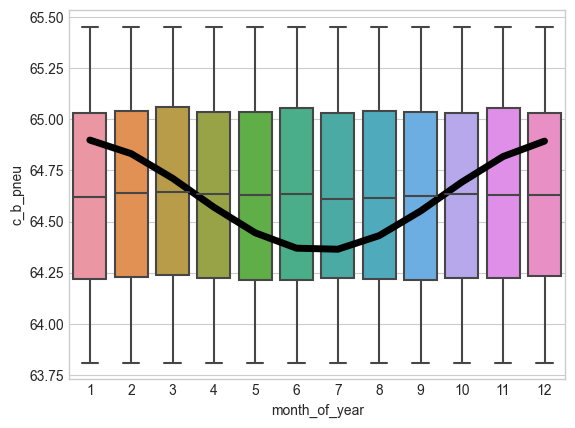

In [231]:
sns.boxplot(data=per_T_neu.query(f'{popt_MoY[0]-3*popt_MoY[1]}<{var}<{popt_MoY[0]+3*popt_MoY[1]}').sample(100_000), x= 'month_of_year', y=var)
plt.plot(cosfun(np.arange(1, 13), *popt_MoY, base_per=12), lw=5, color='black')

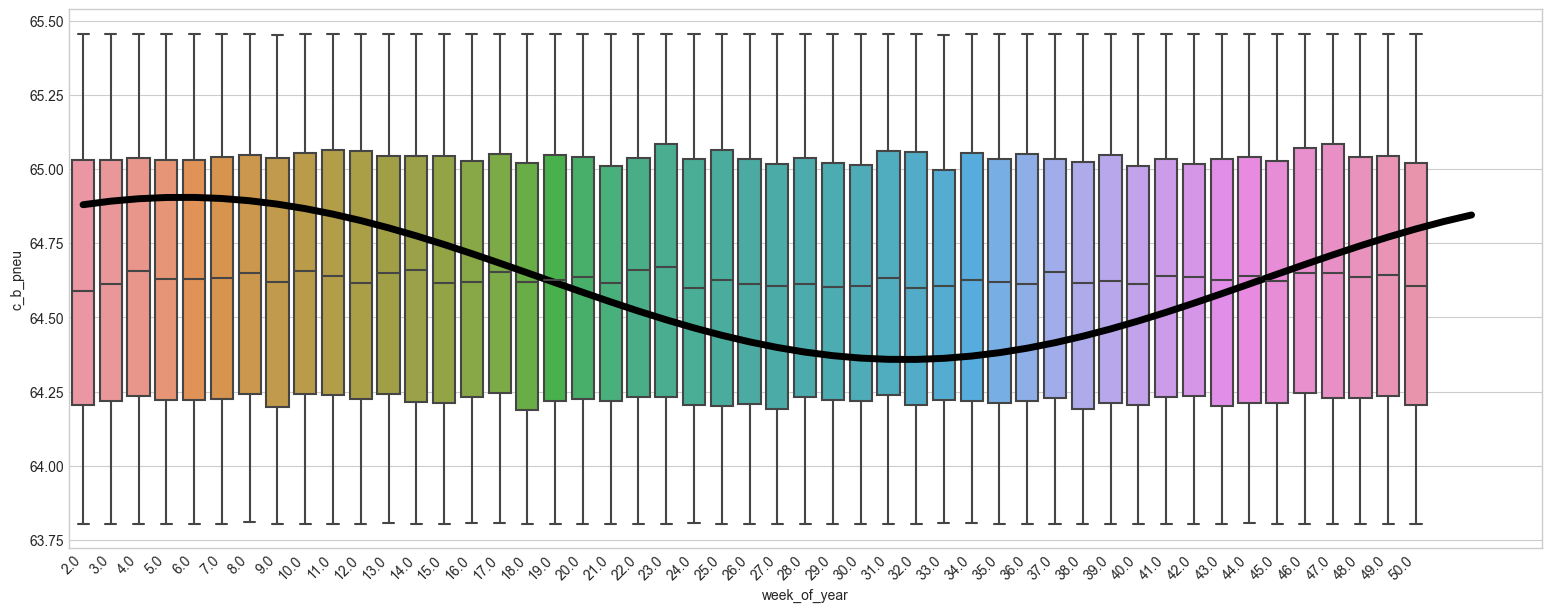

In [232]:
fig, ax = plt.subplots( figsize=(19, 7))
sns.boxplot(data=per_T_neu.query(f'{popt_WoY[0]-3*popt_WoY[1]}<{var}<{popt_WoY[0]+3*popt_WoY[1]}').sample(100_000), x= 'week_of_year', y=var)
plt.plot(cosfun(np.arange(1, 52), *popt_MoY, base_per=52), lw=5, color='black')
# rotate x ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

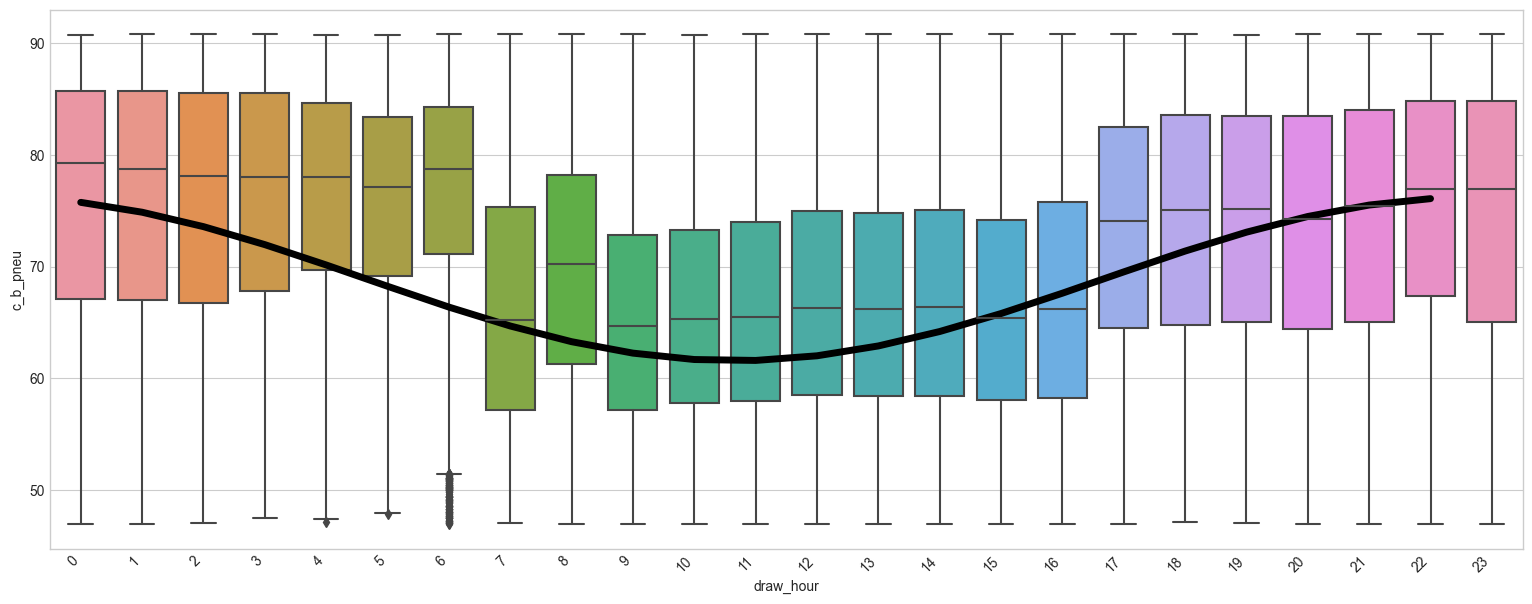

In [238]:
fig, ax = plt.subplots( figsize=(19, 7))
sns.boxplot(data=per_T_neu.query(f'{popt_DH[0]-3*abs(popt_DH[1])}<{var}<{popt_DH[0]+3*abs(popt_DH[1])}').sample(100_000), x= 'draw_hour', y=var)
plt.plot(cosfun(np.arange(1, 24), *popt_DH, base_per=24), lw=5, color='black')
# rotate x ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

In [ ]:
gc.collect()

In [ ]:
# obtain seasonal decomposition using statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
celldyn = celldyn.assign(abs_day=lambda x: x['day_of_year'] + 365*(x['year']-x['year'].min()))
celldyn = celldyn.sort_values(by='abs_day')

In [177]:
var = 'c_b_pneu'
ts = celldyn.query('year<2020')[[var, 'abs_day', 'afname_dt']].dropna(subset=['abs_day'])
# change date period to week
ts['afname_dt'] = ts['afname_dt'].dt.to_period('W')
_ts = ts.groupby('afname_dt').agg(q10=(var, lambda x: x.quantile(0.1)),
                                  q50=(var, lambda x: x.quantile(0.5)),
                                  q90=(var, lambda x: x.quantile(0.9))).reset_index()
# change the frequency of the datetime to day
_ts = _ts.set_index('afname_dt').to_timestamp() # asfreq('W')
_ts = _ts.interpolate(method='linear')

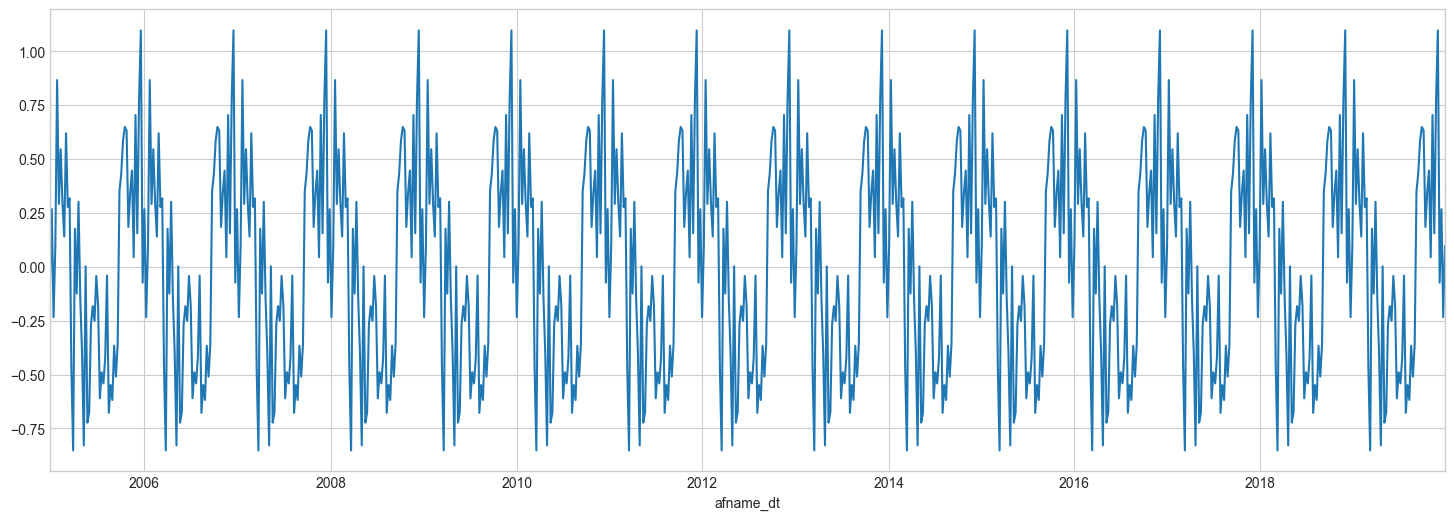

In [246]:
decomposition_week = seasonal_decompose(_ts['q10'], model='additive', period=52)
fig = decomposition_week.seasonal.plot();
fig.figure.set_size_inches(18, 6)

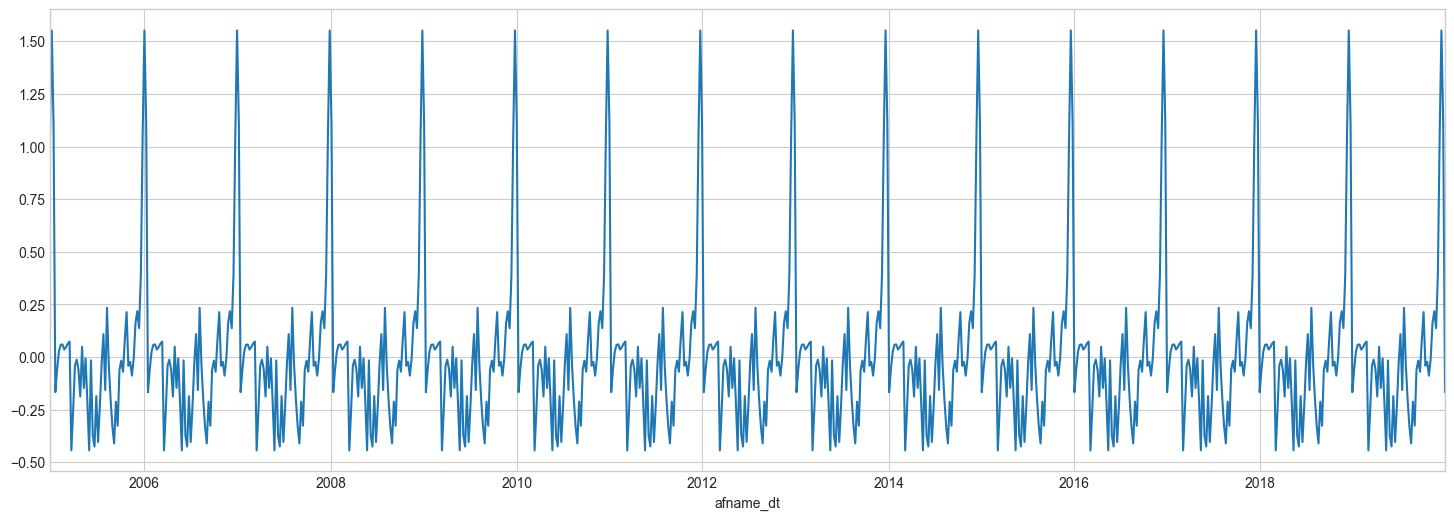

In [247]:
decomposition_week = seasonal_decompose(_ts['q50'], model='additive', period=52)
fig = decomposition_week.seasonal.plot();
fig.figure.set_size_inches(18, 6)

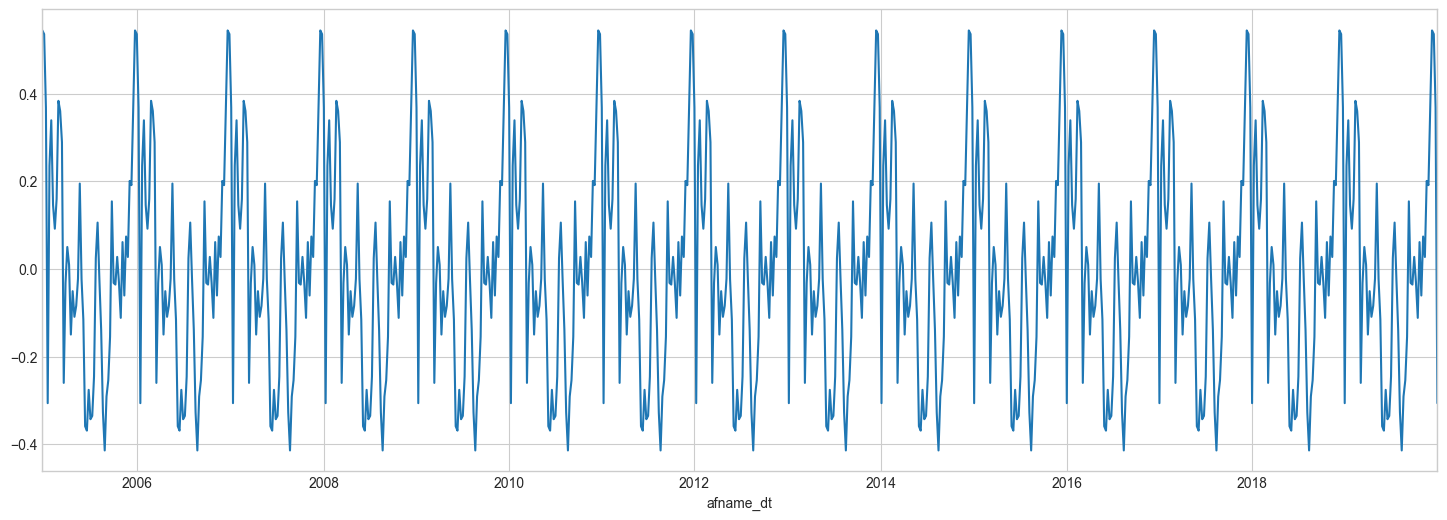

In [248]:
decomposition_week = seasonal_decompose(_ts['q90'], model='additive', period=52)
fig = decomposition_week.seasonal.plot();
fig.figure.set_size_inches(18, 6)

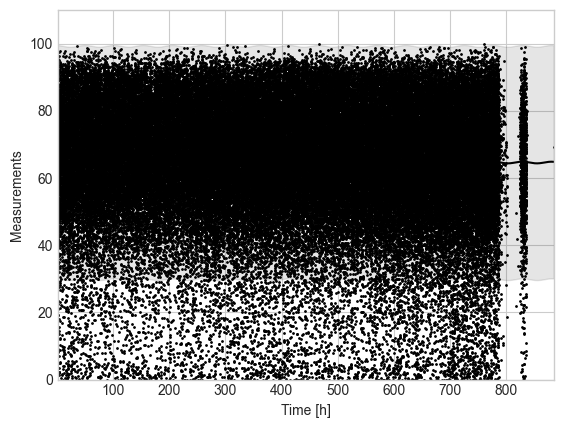

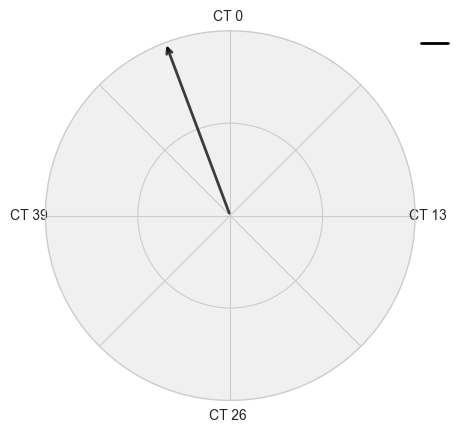

In [269]:
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03830-w
from CosinorPy import file_parser, cosinor, cosinor1

var = 'c_b_pneu'

gc.collect()
df=celldyn.dropna(subset=['abs_day']).sample(100_000)
cosinor_res = cosinor.fit_me(df.abs_week, 
                             df[var],
                             n_components=1,
                             period=52);

In [270]:
cosinor_res

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1f091d32440>,
 {'p': 0.007305270873197323,
  'p_reject': 0.37131531138186424,
  'SNR': 0.009918734541490878,
  'RSS': 31396858.770019297,
  'resid_SE': 17.719424568546355,
  'ME': 34.729854351548866},
 {'period': 52,
  'amplitude': 0.24754010773140322,
  'acrophase': 0.35850006257180755,
  'mesor': 64.5978413454092,
  'peaks': array([49.03303303]),
  'heights': array([64.84537911]),
  'troughs': array([23.11111111]),
  'heights2': array([64.35030379]),
  'max_loc': 471,
  'period2': 52},
 array([  0.        ,   0.1041041 ,   0.20820821,   0.31231231,
          0.41641642,   0.52052052,   0.62462462,   0.72872873,
          0.83283283,   0.93693694,   1.04104104,   1.14514515,
          1.24924925,   1.35335335,   1.45745746,   1.56156156,
          1.66566567,   1.76976977,   1.87387387,   1.97797798,
          2.08208208,   2.18618619,   2.29029029,   2.39439439,
          2.4984985 ,   2.6026026 ,   2.70670671,   2.8

## Weekly variation

In [ ]:
celldyn['day_of_week'] = celldyn.afname_dt.dt.dayofweek

In [ ]:
celldyn['abs_day'] = celldyn['day_of_year'] + 365*(celldyn['year']-celldyn['year'].min())

In [ ]:
var = 'COMBO_PLR'

fig, ax = plt.subplots(nrows=2, figsize=(19, 12))

plt.style.use('seaborn-whitegrid')
plot_df = celldyn.query('abs_week<700 & 1<week_of_year<51')\
                .groupby(['abs_day', 'year'])\
                .agg({var: 'median'}).reset_index()
smoothed= lowess(plot_df[var],
                 plot_df['abs_day'], 
                 frac=0.1, it=3, missing='drop')
sns.lineplot(data=plot_df, x='abs_day', y=var, hue='year', 
            palette='Set2', ax=ax[0], legend=False)
ax[0].plot(smoothed[:,0], smoothed[:,1], color='black', linewidth=3)
ax[0].set_title(f'Median of {var} by day')
#################
################
plot_df = celldyn.query('abs_week<700 & week_of_year<51')\
                .groupby(['day_of_week', 'week_of_year'])\
                .agg({var: 'median'}).reset_index()
sns.lineplot(data=plot_df, x='day_of_week', y=var, hue='week_of_year', 
            palette='Set2', ax=ax[1], legend=False)
ax[1].set_title(f'Median of {var} by day_of_week hour')

## Quick PCA

In [ ]:
X = celldyn.sample(100_000)[meas_cols]
indx = X.index
X = X.assign(had_nans=X.isna().sum(axis=1)>0)
# impute
X = X.fillna(X.median())
# scale
X[meas_cols] = QuantileTransformer(output_distribution='normal').fit_transform(X[meas_cols])



In [ ]:
entropies = []
for c in meas_cols:
   entropies.append((c, get_entropy(X,c)))

In [ ]:
plt.hist([t[1] for t in entropies]);

In [ ]:
drop_cols = [t[0] for t in entropies if t[1]>-4]
X = X.drop(drop_cols, axis=1)

In [ ]:
# PCA
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X[[c for c in meas_cols if c not in drop_cols]])

In [ ]:
###
coloring_by = celldyn.loc[indx, 'age'].values # X.had_nans 

# plot PCA dimensions and color by had_nans, plus add variance explained
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 16))
ax = ax.flatten()
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=coloring_by, cmap='coolwarm', alpha=0.1)
ax[0].set_xlabel('PCA 0')
ax[0].set_ylabel('PCA 1')
ax[0].set_title(f'PCA 0 vs. PCA 1')

ax[1].scatter(X_pca[:, 0], X_pca[:, 2], c=coloring_by, cmap='coolwarm', alpha=0.1)
ax[1].set_xlabel('PCA 0')
ax[1].set_ylabel('PCA 2')
ax[1].set_title(f'PCA 0 vs. PCA 2')

ax[2].scatter(X_pca[:, 1], X_pca[:, 2], c=coloring_by, cmap='coolwarm', alpha=0.1)
ax[2].set_xlabel('PCA 1')
ax[2].set_ylabel('PCA 2')
ax[2].set_title(f'PCA 1 vs. PCA 2')

ax[3].plot(np.cumsum(pca.explained_variance_ratio_))
ax[3].set_xlabel('Number of components')
ax[3].set_ylabel('Cumulative explained variance')
ax[3].set_title(f'PCA explained variance')

## Quick UMAP

In [ ]:
umapper = UMAP(n_components=3)
X_umap = umapper.fit_transform(X[[c for c in meas_cols if c not in drop_cols]])

In [ ]:
###
coloring_by = celldyn.loc[indx, 'age'].values # X.had_nans 

# plot PCA dimensions and color by had_nans, plus add variance explained
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 16))
ax = ax.flatten()
ax[0].scatter(X_umap[:, 0], X_umap[:, 1], c=coloring_by, cmap='coolwarm', alpha=0.1)
ax[0].set_xlabel('U 0')
ax[0].set_ylabel('U 1')
ax[0].set_title(f'U 0 vs. U 1')

ax[1].scatter(X_umap[:, 0], X_umap[:, 2], c=coloring_by, cmap='coolwarm', alpha=0.1)
ax[1].set_xlabel('U 0')
ax[1].set_ylabel('U 2')
ax[1].set_title(f'U 0 vs. U 2')

ax[2].scatter(X_umap[:, 1], X_umap[:, 2], c=coloring_by, cmap='coolwarm', alpha=0.1)
ax[2].set_xlabel('U 1')
ax[2].set_ylabel('U 2')
ax[2].set_title(f'U 1 vs. U 2')


### Patients who have measurements in the evening and during the day

In [ ]:
meas_per_patient = celldyn.shape[0]/celldyn.studyid_alle_celldyn.nunique()
print(f"There are on average {meas_per_patient} measurements per patient")

In [ ]:
counts_per_patient = pd.DataFrame(celldyn.groupby('studyid_alle_celldyn').size(),  
                        columns=['counts_per_patient'])
celldyn = celldyn.merge(counts_per_patient.reset_index(), how='left', on='studyid_alle_celldyn')

In [ ]:
meta_cols = ['asp_dt', 'analyzer', 'studyid_alle_celldyn', 
             'time_to_measurement', 'gender', 'age' , 'afname_dt',
             'day_of_year', 'week_of_year', 'year', 'first_day',
              'draw_hour', 'meas_hour', 'draw_minute', 'draw_hour_dec']

In [ ]:
fig, ax = plt.subplots(figsize=(18,7))
sns.violinplot(data=celldyn[celldyn.counts_per_patient<30], x='counts_per_patient', y='draw_hour')
plt.axhline(7)
plt.axhline(17)

There are three blocks: 
* routine block: from 7AM to 5PM, mostly poli perhaps?
* evening block: from 5PM to 12PM
* morning block: from 12PM to 7AM

In [ ]:
celldyn.loc[:,'care_block'] = celldyn.apply(lambda x: 'routine_block'\
                                    if (x['draw_hour']>=7) & (x['draw_hour']<17)
                                    else 'evening_block' if (x['draw_hour']>=17) & (x['draw_hour']<=23)
                                    else 'morning_block', axis=1
)
meta_cols.append('care_block')
celldyn = celldyn.assign(draw_minute=celldyn.afname_dt.dt.minute)

In [ ]:
celldyn = celldyn.assign(draw_hour_dec=celldyn[['draw_hour', 'draw_minute']].apply(lambda x: round(x[0]+x[1]/60, 1), axis=1))


In [ ]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_bas.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_eos.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_neu.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_seg.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

plot_df.rename(columns={'level_1': 'percentile'}, inplace=True)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_bas', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_eos', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_neu', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_seg', color='black', ax=ax[1,1])

ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

plt.suptitle('Hourly variation in granulocytes', fontsize=16)

In [ ]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_mon.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_mone.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_lym.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
plot_df.rename(columns={'level_1': 'percentile'}, inplace=True)

fig, ax = plt.subplots(ncols=3, figsize=(22,4))
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mon', color='black', ax=ax[0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mone', color='black', ax=ax[1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_lym', color='black', ax=ax[2])
# seg
ax[0].set_xlabel('Hour of the day')
ax[1].set_xlabel('Hour of the day')
ax[2].set_xlabel('Hour of the day')

plt.suptitle('Hourly variation in agranulocytes', fontsize=16)

In [ ]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_retc.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_rbci.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_irf.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_wbc.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

plot_df.rename(columns={'level_1': 'percentile'}, inplace=True)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_retc', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_rbci', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_irf', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_wbc', color='black', ax=ax[1,1])

ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Reticulocytes')
ax[0,1].set_ylabel('RBC impedance')
ax[1,0].set_ylabel('Immature reticuloctye fraction')
ax[1,1].set_ylabel('White blood cell count')

plt.suptitle('Hourly variation in red/white blood cells ', fontsize=16)

In [ ]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_plti.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_plto.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(22,4))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plti', color='black', ax=ax[0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plto', color='black', ax=ax[1])

ax[0].set_xlabel('Hour of the day')
ax[1].set_xlabel('Hour of the day')

ax[0].set_ylabel('PLT impedance')
ax[1].set_ylabel('PLT optics')

plt.suptitle('Hourly variation in platelets ', fontsize=16)

In [ ]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_mcv.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_mch.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_mchc.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_rdw.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
          
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mcv', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mch', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mchc', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_rdw', color='black', ax=ax[1,1])


ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Mean corpuscular volume')
ax[0,1].set_ylabel('Mean corpuscular hemoglobin')
ax[1,0].set_ylabel('Mean corpuscular hemoglobin concentration')
ax[1,1].set_ylabel('Red cell distribution width')

plt.suptitle('Hourly variation of aggregate blood parameters ', fontsize=16)

In [ ]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_plti.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_plto.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(22,4))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plti', color='black', ax=ax[0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plto', color='black', ax=ax[1])

ax[0].set_xlabel('Hour of the day')
ax[1].set_xlabel('Hour of the day')

ax[0].set_ylabel('PLT impedance')
ax[1].set_ylabel('PLT optics')

plt.suptitle('Hourly variation in platelets ', fontsize=16)

In [ ]:
# wbc/(retc+irf), neu/seg, lym/mon, wbc/plti, plti/(retc+irf), wbc/(mon+lym), ig/(bas+neu+eos), retc/hb, wbc/rbci, rbci/(retc+irf)

celldyn = celldyn.assign(wbc_over_rbc=0.5*celldyn.c_b_wbc/(celldyn.c_b_rbci+celldyn.c_b_rbco))
celldyn = celldyn.assign(neu_over_seg=celldyn.c_b_neu/celldyn.c_b_seg)
celldyn = celldyn.assign(neu_over_wbc=celldyn.c_b_neu/(celldyn.c_b_wbc-celldyn.c_b_neu))
celldyn = celldyn.assign(lym_over_mon=celldyn.c_b_lym/celldyn.c_b_mon)
celldyn = celldyn.assign(wbc_over_plt=celldyn.c_b_wbc/celldyn.plt) # plti, plto
celldyn = celldyn.assign(plt_over_rbc=0.5*celldyn.plt/(celldyn.c_b_rbci+celldyn.c_b_rbco))
celldyn = celldyn.assign(retc_over_hb=celldyn.c_b_retc/celldyn.c_b_hb)
celldyn = celldyn.assign(rbc_over_irbc=celldyn.c_b_rbci/(celldyn.c_b_retc+celldyn.c_b_irf))
celldyn = celldyn.assign(plt_over_lym=celldyn.plt/celldyn.c_b_lym)

In [ ]:
# wbc_over_rbc
# neu_over_seg
# plt_over_rbc
# wbc_over_plt

plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').wbc_over_rbc.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').neu_over_seg.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').plt_over_rbc.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').wbc_over_plt.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
          
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='wbc_over_rbc', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='neu_over_seg', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='plt_over_rbc', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='wbc_over_plt', color='black', ax=ax[1,1])


ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Leukocyte/erytrocyte ratio')
ax[0,1].set_ylabel('Neutrophil/segment ratio')
ax[1,0].set_ylabel('Platelet/erytrocyte ratio')
ax[1,1].set_ylabel('Leukocyte/platelet ratio')

plt.suptitle('Hourly variation of hematology ratios ', fontsize=16)

In [ ]:
# 'neu:lym'
# 'mon:lym'
#  plt_over_lym
#  retc_over_hb

plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec')['neu:lym'].quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec')['mon:lym'].quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').plt_over_lym.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').retc_over_hb.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
          
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='neu:lym', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='mon:lym', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='plt_over_lym', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='retc_over_hb', color='black', ax=ax[1,1])


ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Neutrophil/lymphocyte ratio')
ax[0,1].set_ylabel('Monocyte/lymphocyte ratio')
ax[1,0].set_ylabel('Platelet/lymphocyte ratio')
ax[1,1].set_ylabel('Reticulocyte/hemoglobin ratio')

plt.suptitle('Hourly variation of hematology ratios ', fontsize=16)

In [ ]:
meas_cols.extend(['wbc_over_rbc', 'neu_over_seg', 'lym_over_mon', 'wbc_over_plt', 'neu_over_wbc',
                  'plt_over_rbc', 'retc_over_hb', 'rbc_over_irbc', 'plt_over_lym'])

In [ ]:
relnum_unique = pd.DataFrame(celldyn.nunique()/celldyn.shape[0])
relnum_unique.columns = ['relnum_unique']

In [ ]:
keep_meas_cols = relnum_unique.loc[meas_cols].query('relnum_unique>0.1').sort_values('relnum_unique', ascending=False).index

# Identify exemplars

In [ ]:
feature_correlations = []
for i in tqdm(range(20)):
    feature_correlations.append(celldyn.sample(5000)[keep_meas_cols].corr(method='kendall'))

In [ ]:
from sklearn.cluster import AffinityPropagation

In [ ]:
w = 2
count_dict = defaultdict(int)
for corss in feature_correlations:
    af_clust = AffinityPropagation(random_state=0, affinity='precomputed')
    af_clust.fit(1-np.exp(w*(1-corss)))
    for exemplar in corss.columns[af_clust.cluster_centers_indices_]:
        count_dict[exemplar] += 1/len(feature_correlations)

In [ ]:
pd.DataFrame(count_dict, index=[1]).T.rename(columns={1:'count'}).sort_values('count', ascending=False)

## Reduce dimensionality

In [ ]:
reduced_dimensions = 6
# manhattan: 40s, 50.000 samples
# poincarre: 4m, 50.000 samples
# fractional_distance: 2m, 50.000 samples
dist =  fractional_distance #, poincarre_dist, manhattan, hyperboloid_dist
reducer = UMAP(n_components=reduced_dimensions, n_neighbors=50, n_jobs=8, min_dist=0, metric=dist, densmap=False)
emb_cols = [f'dim_{i}' for i in range(reduced_dimensions)]

sample_index = celldyn.dropna(subset=keep_meas_cols).sample(250000).index
celldyn_embedded = celldyn.loc[sample_index, meta_cols].copy()
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    ('Scaling Q', QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=42)),
    ('Embedder', reducer),
])
reduce_pipe.fit(celldyn.loc[sample_index, keep_meas_cols])
celldyn_embedded.loc[:, emb_cols] = reduce_pipe.transform(celldyn.loc[sample_index, keep_meas_cols])
celldyn_embedded = celldyn_embedded.assign(normal_prick=celldyn_embedded.draw_hour==8)

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter_3d(celldyn_embedded.sample(10000), x='dim_0', y='dim_1', z='dim_2',
                    color='age', size_max=7, opacity=0.15)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [ ]:
nqs = [0.25, 0.5, 0.75]
reso = 'draw_hour_dec'
aggvar = 'quantile'

plot_df = celldyn_embedded.sample(250000)
plot_df = plot_df.groupby(reso).dim_0.quantile(nqs).to_frame().join(
          plot_df.groupby(reso).dim_1.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_2.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_3.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_4.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_5.quantile(nqs).to_frame()).reset_index()
plot_df = plot_df.rename(columns={'level_1': 'quantile'})

          
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(22,12))

sns.lineplot(data=plot_df, x=reso, y='dim_0', hue=aggvar, ax=ax[0,0])
sns.lineplot(data=plot_df, x=reso, y='dim_1', hue=aggvar, ax=ax[0,1])
sns.lineplot(data=plot_df, x=reso, y='dim_2', hue=aggvar, ax=ax[0,2])

sns.lineplot(data=plot_df, x=reso, y='dim_3', hue=aggvar, ax=ax[1,0])
sns.lineplot(data=plot_df, x=reso, y='dim_4', hue=aggvar, ax=ax[1,1])
sns.lineplot(data=plot_df, x=reso, y='dim_5', hue=aggvar, ax=ax[1,2])

ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[0,2].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')
ax[1,2].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('embedded dimension 0')
ax[0,1].set_ylabel('embedded dimension 1')
ax[0,2].set_ylabel('embedded dimension 2')

ax[1,0].set_ylabel('embedded dimension 3')
ax[1,1].set_ylabel('embedded dimension 4')
ax[1,2].set_ylabel('embedded dimension 5')

plt.suptitle('Hourly variation of embedded values ', fontsize=16)
plt.savefig(f'./../artifacts/embedding_intraday_variation.eps', dpi=300, bbox_inches='tight')

In [ ]:
nqs = [0.25, 0.5, 0.75]
reso = 'age'
aggvar = 'quantile'

plot_df = celldyn_embedded.loc[celldyn_embedded.age.between(0,90)]
plot_df = plot_df.groupby(reso).dim_0.quantile(nqs).to_frame().join(
          plot_df.groupby(reso).dim_1.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_2.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_3.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_4.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_5.quantile(nqs).to_frame()).reset_index()
plot_df = plot_df.rename(columns={'level_1': 'quantile'})

          
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(22,12))

sns.lineplot(data=plot_df, x=reso, y='dim_0', hue=aggvar, ax=ax[0,0])
sns.lineplot(data=plot_df, x=reso, y='dim_1', hue=aggvar, ax=ax[0,1])
sns.lineplot(data=plot_df, x=reso, y='dim_2', hue=aggvar, ax=ax[0,2])

sns.lineplot(data=plot_df, x=reso, y='dim_3', hue=aggvar, ax=ax[1,0])
sns.lineplot(data=plot_df, x=reso, y='dim_4', hue=aggvar, ax=ax[1,1])
sns.lineplot(data=plot_df, x=reso, y='dim_5', hue=aggvar, ax=ax[1,2])

ax[0,0].set_xlabel('Age')
ax[0,1].set_xlabel('Age')
ax[0,2].set_xlabel('Age')
ax[1,0].set_xlabel('Age')
ax[1,1].set_xlabel('Age')
ax[1,2].set_xlabel('Age')

ax[0,0].set_ylabel('embedded dimension 0')
ax[0,1].set_ylabel('embedded dimension 1')
ax[0,2].set_ylabel('embedded dimension 2')

ax[1,0].set_ylabel('embedded dimension 3')
ax[1,1].set_ylabel('embedded dimension 4')
ax[1,2].set_ylabel('embedded dimension 5')

plt.suptitle('Age variation of embedded values ', fontsize=16)
plt.savefig(f'./../artifacts/embedding_intraAge_variation.eps', dpi=300, bbox_inches='tight')

In [ ]:
PCA_reducer = PCA()
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    ('Scaling Q', QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=42)),
    ('Reduce', PCA_reducer)])
reduce_pipe.fit(celldyn.loc[sample_index, keep_meas_cols])

In [ ]:
plt.plot(np.cumsum(reduce_pipe.named_steps['Reduce'].explained_variance_ratio_))
plt.axhline(0.95, color='red')

In [ ]:
n_comps = 3
PCA_reducer = FactorAnalysis(rotation='varimax', n_components=n_comps)
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    ('Scaling Q', QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=42)),
    ('Reduce', PCA_reducer)])
reduce_pipe.fit(celldyn.loc[sample_index, keep_meas_cols])

FA_weights = pd.DataFrame(data=reduce_pipe.named_steps['Reduce'].components_, columns=keep_meas_cols, index=['comp_{}'.format(i) for i in range(n_comps)])

In [ ]:
FA_weights

In [ ]:
nred = 32
NMF_reducer = NMF(l1_ratio=1, max_iter=2000, n_components=nred)
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    ('Scaling Q', QuantileTransformer(n_quantiles=500, output_distribution='uniform', random_state=42)),
    ('Reduce', NMF_reducer)])
reduce_pipe.fit(celldyn.loc[sample_index, keep_meas_cols])

NMF_weights = pd.DataFrame(data=reduce_pipe.named_steps['Reduce'].components_, columns=keep_meas_cols, 
                           index=['comp_{}'.format(i) for i in range(nred)])

In [ ]:
NMF_reducer.reconstruction_err_

In [ ]:
NMF_weights.sum(axis=0).sort_values(ascending=False)[:25]

In [ ]:
sPCA_reducer = SparsePCA(method='lars', max_iter=1500)
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    #('Scaling Q', QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=123)),
    ('Scaling S', StandardScaler()),
    ('Reduce', sPCA_reducer)])
reduce_pipe.fit(celldyn.loc[sample_index, keep_meas_cols])

sPCA_weights = pd.DataFrame(data=reduce_pipe.named_steps['Reduce'].components_, columns=keep_meas_cols, 
                            index=['comp_{}'.format(i) for i in range(len(keep_meas_cols))])

In [ ]:
sPCA_weights.columns[(sPCA_weights!=0).sum(axis=0)>1]

In [ ]:
qt =  QuantileTransformer(n_quantiles=50, output_distribution='normal', random_state=123)
sparse_coded_celldyn = SparseCoder(dictionary=qt.fit_transform(celldyn.loc[sample_index, keep_meas_cols].T.values))\
                                                .fit_transform(celldyn.loc[sample_index, keep_meas_cols].T.values)
sCoded_recon = pd.DataFrame(data=sparse_coded_celldyn, columns=keep_meas_cols, 
                            index=['comp_{}'.format(i) for i in range(len(keep_meas_cols))])

In [ ]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
import dcor

In [ ]:
# how important is each component in reconstructing the original data
# - sub sample
#   -- determine the distance matrix between the samples on the basis of the original components
#   -- randomly permute the components and retry

def get_distance(X: np.array)-> np.array:
    return pdist(X, metric='cityblock')

def get_rank(D)-> np.array:
    return np.argsort(D)

@lru_cache(maxsize=None)
def permute_vector(l=1000, n=0):
    return np.random.permutation(l)

def get_permuted_rank(X, n_perm=10):
    num_features = X.shape[1]
    num_samples = X.shape[0]

    perm_vectors = [permute_vector(l=num_samples, n=n) for n in range(n_perm)]

    res_array = []    
    for d in range(num_features):
        sub_list = []
        for n in range(n_perm):
            X_perm = X.copy()
            X_perm[:, d] = X[perm_vectors[n], d]
            rank_vector = get_rank(get_distance(X_perm))
            sub_list.append(rank_vector)
        res_array.append(sub_list)
    return res_array

def get_perturbed_rank(X, n_pert=10):
    num_features = X.shape[1]
    num_samples = X.shape[0]

    stats_list = []
    for d in range(num_features):
        stats_list.append((np.mean(X[:, d]), np.std(X[:, d])))

    res_array = []    
    for d in range(num_features):
        sub_list = []
        for n in range(n_pert):
            perburbation_vector = np.random.normal(loc=0, scale=2*stats_list[d][1], size=num_samples)
            X_perb = X.copy()
            X_perb[:, d] = X[:, d] + perburbation_vector
            rank_vector = get_rank(get_distance(X_perb))
            sub_list.append(rank_vector)
        res_array.append(sub_list)
    return res_array

def rank_match(v1,v2):
    return np.sum(v1-v2)/len(v1)

def repeated_agreement_metric(v1, v2, num_rounds=100, num_per_round=100):
    scores = []
    for _ in range(num_rounds):
        batch = np.random.choice(len(v1), size=num_per_round, replace=True)
        score = cohen_kappa_score(v1[batch], v2[batch])
        scores.append(score)
    return np.mean(scores)

def compare_rank_with_original(X, rank_metric='correlation', n_perm=10, n_pert=10, how='permutation'):
    orank = get_rank(get_distance(X))

    if how == 'permutation':
        changed_ranks = get_permuted_rank(X, n_perm=n_perm)
    elif how== 'perturbation':
        changed_ranks = get_perturbed_rank(X, n_pert=n_pert)
    else:
        raise ValueError('how should be either permutation or perturbation')

    # rank-distance
    res = []
    for d in range(X.shape[1]):
        sub_res = []
        for prank in changed_ranks[d]:
            sub_res.append(repeated_agreement_metric(orank.ravel(), prank.ravel()))
        res.append(sub_res)
    return res

def get_permuted_distance_correlation(X, n_perm=10):
    num_features = X.shape[1]
    num_samples = X.shape[0]
    res = []
    for d in tqdm(range(num_features)):
        sub_list = []
        for n in range(n_perm):
            X_perm = X.copy()
            X_perm[:, d] = X[permute_vector(l=num_samples, n=n), d]
            sub_list.append(dcor.distance_correlation(X, X_perm))
        res.append(sub_list)
    return res

def get_perturbed_distance_correlation(X, n_perm=10):
    num_features = X.shape[1]
    num_samples = X.shape[0]
        	
    stats_list = []
    for d in range(num_features):
        stats_list.append((np.mean(X[:, d]), np.std(X[:, d])))

    res = []
    for d in tqdm(range(num_features)):
        sub_list = []
        for n in range(n_perm):
            perburbation_vector = np.random.normal(loc=1, scale=4*stats_list[d][1]/np.abs(stats_list[d][0]), size=num_samples)
            X_perm = X.copy()
            X_perm[:, d] = X[:, d] * perburbation_vector
            dist = dcor.distance_correlation(X, X_perm)
            sub_list.append(dist)
        res.append(sub_list)
    return res


In [ ]:
np_perm = 5
np_pert = 5
sample_size = 1000
rank_results = compare_rank_with_original(QuantileTransformer(output_distribution='normal', n_quantiles=100)\
                            .fit_transform(celldyn.dropna().sample(sample_size).loc[:, keep_meas_cols].values), 
                            n_perm=np_perm, n_pert=np_pert, how='perturbation')
rank_results_df = pd.DataFrame(rank_results, index=keep_meas_cols, columns=[f'round_{i}' for i in range(np_perm)])

In [ ]:
np_perm = 100
dist_results = get_perturbed_distance_correlation(QuantileTransformer(output_distribution='normal', n_quantiles=100)\
                                                  .fit_transform(celldyn.dropna().sample(sample_size).loc[:, keep_meas_cols].values), n_perm=np_perm)
dist_results_df = pd.DataFrame(dist_results, index=keep_meas_cols, columns=[f'round_{i}' for i in range(np_perm)])

In [ ]:
rank_results_df.mean(axis=1).sort_values(ascending=False)[:20]

In [ ]:
dist_results_df.mean(axis=1).sort_values(ascending=False)[:20]

# Concrete AutoEncoder

In [ ]:
from concrete_autoencoder import ConcreteAutoencoderFeatureSelector
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, LeakyReLU
from sklearn.model_selection import train_test_split

In [ ]:
X  = QuantileTransformer(output_distribution='normal', n_quantiles=250).fit_transform(celldyn.dropna().sample(100000).loc[:, meas_cols].values)

num_rounds = 100
feature_selection = []
for _ in tqdm(range(num_rounds)):
    x_train, x_test, _, _ = train_test_split(X, X, test_size=0.2, random_state=None)
    x_train = np.reshape(x_train, (len(x_train), -1))
    x_test = np.reshape(x_test, (len(x_test), -1))

    def decoder(x):
        x = Dense(512)(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(0.1)(x)
        x = Dense(512)(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(0.1)(x)
        x = Dense(X.shape[1])(x)
        return x

    selector = ConcreteAutoencoderFeatureSelector(K = 32, output_function = decoder, num_epochs = 450)

    selector.fit(x_train, x_train, x_test, x_test)
    feature_selection.append(np.array(meas_cols)[selector.get_support(indices=True)])

In [ ]:
count_dict = defaultdict(int)

for i in feature_selection:
    for j in i:
        count_dict[j] += 1/len(feature_selection)
        
    presence_df = pd.DataFrame(count_dict, index=[0]).T.sort_values(by=0, ascending=False).rename(columns={0:'presence'})

In [ ]:
presence_df[:20]

In [ ]:
# https://github.com/bwohlberg/sporco